<a href="https://colab.research.google.com/github/mirtorande/muffin-vs-chihuahua/blob/main/MuffinsChihuahuas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
! pip install -qq wandb
import wandb
from wandb.keras import WandbMetricsLogger
wandb.login()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
from tensorflow.keras.utils import plot_model
import numpy as np

wandb: Currently logged in as: mirtorande (minigi). Use `wandb login --relogin` to force relogin


In [2]:
# Define a config dictionary object
configs = dict(
    image_size = 64,
    batch_size = 32,
    epochs = 50,
    optimizer = 'adam',
    loss_fn = 'binary_crossentropy',
    metrics = ['acc'],
)

## Load the data: the Muffins vs Chihuahuas dataset

### Data download


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = "/content/drive/My Drive/Datasets/archive"

### Filter out the corrupted images

In [5]:
"""num_skipped = 0
for folder_name in ('test/chihuahua', 'train/chihuahua', 'test/muffin', 'train/muffin'):
    folder_path = os.path.join(dataset_path, folder_name)
    for fname in tqdm(os.listdir(folder_path)):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)"""


'num_skipped = 0\nfor folder_name in (\'test/chihuahua\', \'train/chihuahua\', \'test/muffin\', \'train/muffin\'):\n    folder_path = os.path.join(dataset_path, folder_name)\n    for fname in tqdm(os.listdir(folder_path)):\n        fpath = os.path.join(folder_path, fname)\n        try:\n            fobj = open(fpath, "rb")\n            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)\n        finally:\n            fobj.close()\n\n        if not is_jfif:\n            num_skipped += 1\n            # Delete corrupted image\n            os.remove(fpath)\n\nprint("Deleted %d images" % num_skipped)'

### Generate a Dataset

In [6]:
def load_datasets(config):
  """
  Loads Training and Test datasets
  """
  image_size = (config['image_size'], config['image_size']) # (224, 224) originally
  batch_size = config['batch_size'] # 32 originally

  train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
      dataset_path + '/train',
      image_size=image_size,
      batch_size=batch_size,
      validation_split = 0.2,
      subset='both',
      shuffle=True,
      seed=1337
  )

  test_ds = tf.keras.utils.image_dataset_from_directory(
      dataset_path + '/test',
      image_size=image_size,
      batch_size=batch_size,
      shuffle=False
  )
  return train_ds, val_ds, test_ds

## Visualize the data

In [7]:
def print_class_counts(dataset):
  n_muf=0
  n_chi = 0
  for images, labels in tqdm(dataset):
    for label in labels:
      if label == 0:
        n_chi += 1
      else:
        n_muf += 1

  print(n_muf, n_chi)

In [8]:
def show_sample_figures(dataset):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(int(labels[i]))
          plt.axis("off")

## Using image data augmentation

In [9]:
def augment_dataset(dataset, show_preview=False):
  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
      ]
  )

  # Show augmentation preview
  if show_preview:
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[1].numpy().astype("uint8"))
            plt.axis("off")

  # Apply `data_augmentation` to the training images.
  dataset = dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
  )

  return dataset

In [10]:
def prefetch_datasets(train_ds, test_ds):
  # Prefetching samples in GPU memory helps maximize GPU utilization.
  train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
  test_ds = test_ds.prefetch(tf.data.AUTOTUNE)
  return train_ds, test_ds

# Build the model

In [11]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [256, 512, 728]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(size, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)

  return keras.Model(inputs, outputs)

# Train the model

In [12]:
def train_model(config, train_ds, test_ds):
  model = make_model(input_shape=(config.image_size, config.image_size) + (3,), num_classes=2)
  keras.utils.plot_model(model, show_shapes=True)

  epochs = config.epochs

  model.compile(
      optimizer=keras.optimizers.Adam(config.init_learning_rate),
      loss=config.loss_fn,
      metrics=["accuracy"],
  )

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, start_from_epoch=5), WandbMetricsLogger(log_freq=2)]

  history = model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=test_ds,
  )
  return history

# Objective

Found 4733 files belonging to 2 classes.
Using 3787 files for training.
Using 946 files for validation.
Found 1184 files belonging to 2 classes.


  0%|          | 0/119 [00:00<?, ?it/s]

1742 2045


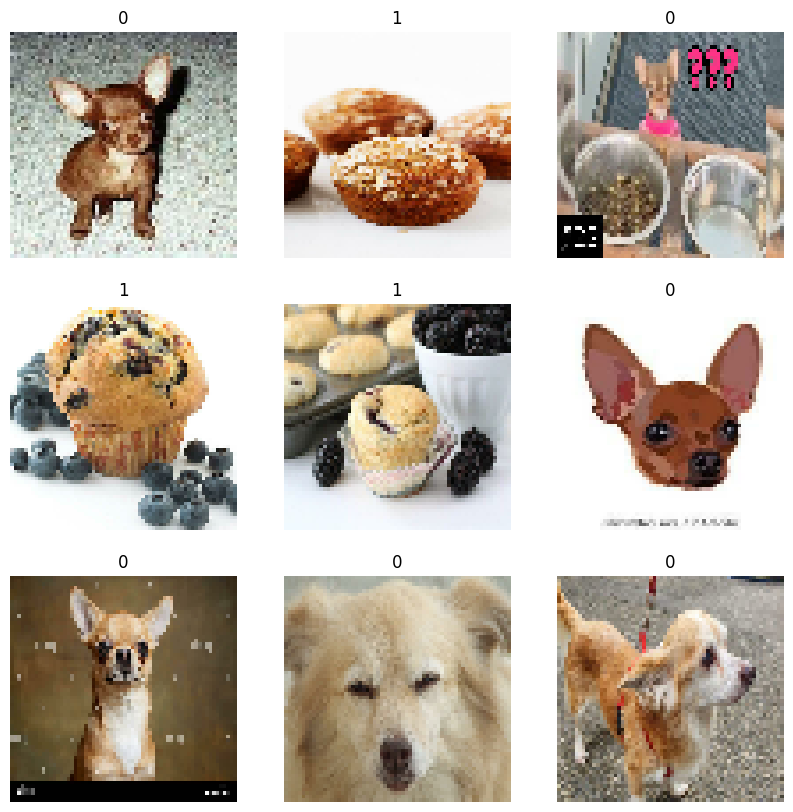

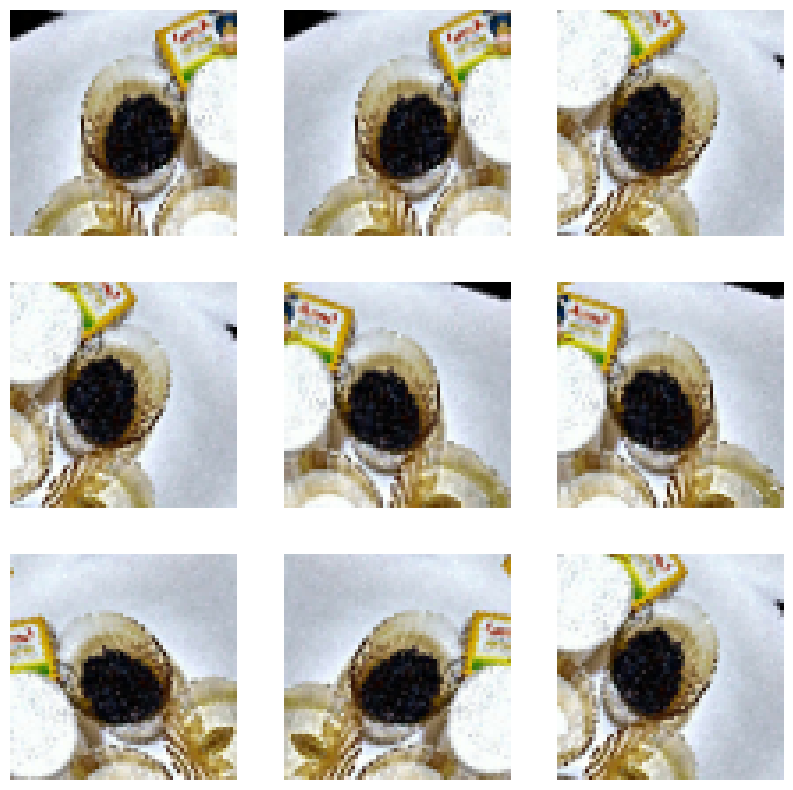

In [18]:
train, val, _ = load_datasets(configs)
print_class_counts(train)
show_sample_figures(train)
train = augment_dataset(train, show_preview=True)
train, val = prefetch_datasets(train, val)

In [14]:
def objective(config, train, val):
  history = train_model(config, train, val)
  return max(history.history['val_accuracy'])

In [15]:
def main():
    wandb.init()
    val_accuracy = objective(wandb.config, train, val)
    wandb.log({'val_accuracy': val_accuracy})

# 2: Define the search space
sweep_configuration = {
    'method': 'bayes',
    'metric':
    {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters':
    {
        'init_learning_rate': {'distribution': 'log_uniform_values', 'max': 1e-2, 'min': 1e-5},
    }
}
sweep_configuration['parameters'].update({attribute:{'value':value} for attribute, value in configs.items()})

# 3: Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project='MuffinChihuahuas'
    )

wandb.agent(sweep_id, function=main, count=10)

Create sweep with ID: qiy27mo6
Sweep URL: https://wandb.ai/minigi/MuffinChihuahuas/sweeps/qiy27mo6


wandb: Agent Starting Run: 7h9zagsm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 9.795739961978613e-05
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 19s 52ms/step - loss: 0.4236 - accuracy: 0.8115 - val_loss: 0.6913 - val_accuracy: 0.5433
Epoch 2/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3408 - accuracy: 0.8574 - val_loss: 0.6938 - val_accuracy: 0.4567
Epoch 3/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3046 - accuracy: 0.8751 - val_loss: 0.7014 - val_accuracy: 0.4567
Epoch 4/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2631 - accuracy: 0.8862 - val_loss: 0.6923 - val_accuracy: 0.4609
Epoch 5/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2564 - accuracy: 0.8912 - val_loss: 0.5783 - val_accuracy: 0.6818
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2348 - accuracy: 0.9065 - val_loss: 0.4549 - val_accuracy: 0.8034
Epoch 7/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2172 - accuracy: 0.9097 - val_loss: 0.2255 - val_accuracy: 0.917

batch/accuracy,▁▂▃▄▆▆▆▆▅▆▆▆▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▄▄▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▅▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▃▃▃▂▂▂▁
epoch/val_accuracy,▂▁▁▁▄▆█▇█▇
epoch/val_loss,████▆▄▁▂▂▃
val_accuracy,▁


wandb: Agent Starting Run: bgwkykch with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 0.00023296204756621404
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 15s 48ms/step - loss: 0.4284 - accuracy: 0.8159 - val_loss: 0.6925 - val_accuracy: 0.5222
Epoch 2/50
119/119 [==============================] - 6s 48ms/step - loss: 0.3243 - accuracy: 0.8637 - val_loss: 0.6894 - val_accuracy: 0.5433
Epoch 3/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2957 - accuracy: 0.8809 - val_loss: 0.6886 - val_accuracy: 0.5402
Epoch 4/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2473 - accuracy: 0.8991 - val_loss: 0.6892 - val_accuracy: 0.5433
Epoch 5/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2368 - accuracy: 0.9063 - val_loss: 0.6272 - val_accuracy: 0.5814
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2100 - accuracy: 0.9184 - val_loss: 0.3582 - val_accuracy: 0.8277
Epoch 7/50
119/119 [==============================] - 6s 50ms/step - loss: 0.2123 - accuracy: 0.9144 - val_loss: 0.2392 - val_accuracy: 0.900

batch/accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▆▇▇▇▇█████▇██████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▄▄▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁
epoch/accuracy,▁▄▅▆▆▇▆▇████
epoch/epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▃▃▃▂▂▁▁▁
epoch/val_accuracy,▁▁▁▁▂▆█▇█▆█▇
epoch/val_loss,████▇▃▁▂▁▄▂▅
val_accuracy,▁


wandb: Agent Starting Run: azj5etiv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 0.0013836812074124684
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 14s 46ms/step - loss: 0.4207 - accuracy: 0.8268 - val_loss: 1.0211 - val_accuracy: 0.5433
Epoch 2/50
119/119 [==============================] - 6s 50ms/step - loss: 0.3293 - accuracy: 0.8693 - val_loss: 1.2133 - val_accuracy: 0.5433
Epoch 3/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2947 - accuracy: 0.8817 - val_loss: 1.0222 - val_accuracy: 0.5433
Epoch 4/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2673 - accuracy: 0.8904 - val_loss: 0.9924 - val_accuracy: 0.5677
Epoch 5/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2498 - accuracy: 0.8946 - val_loss: 0.7869 - val_accuracy: 0.7072
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2320 - accuracy: 0.9020 - val_loss: 0.3300 - val_accuracy: 0.8520
Epoch 7/50
119/119 [==============================] - 6s 50ms/step - loss: 0.2196 - accuracy: 0.9107 - val_loss: 0.3405 - val_accuracy: 0.864

batch/accuracy,▁▃▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████▇████████▇██
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁
epoch/accuracy,▁▄▅▅▅▆▇▇▇▇██▇
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▂▂▂▂▁▁▂
epoch/val_accuracy,▁▁▁▁▄▇▇▄███▇█
epoch/val_loss,▇█▇▆▅▂▂▅▁▁▁▁▁
val_accuracy,▁


wandb: Agent Starting Run: kfew9kcn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 0.00928980207848109
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 15s 50ms/step - loss: 0.6929 - accuracy: 0.7164 - val_loss: 0.8367 - val_accuracy: 0.5433
Epoch 2/50
119/119 [==============================] - 6s 48ms/step - loss: 0.4997 - accuracy: 0.7890 - val_loss: 0.7732 - val_accuracy: 0.5592
Epoch 3/50
119/119 [==============================] - 6s 49ms/step - loss: 0.4270 - accuracy: 0.8273 - val_loss: 1.1145 - val_accuracy: 0.5930
Epoch 4/50
119/119 [==============================] - 6s 48ms/step - loss: 0.4033 - accuracy: 0.8439 - val_loss: 0.6039 - val_accuracy: 0.7209
Epoch 5/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3800 - accuracy: 0.8516 - val_loss: 0.7702 - val_accuracy: 0.6036
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.3460 - accuracy: 0.8553 - val_loss: 0.6353 - val_accuracy: 0.5846
Epoch 7/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3172 - accuracy: 0.8696 - val_loss: 0.4925 - val_accuracy: 0.768

batch/accuracy,▁▃▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇▇█▇█████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▆▇▇█████
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▁▂▅▂▂▆▂██▇▇▇
epoch/val_loss,▆▅█▄▅▄▃▅▁▁▂▂▂
val_accuracy,▁


wandb: Agent Starting Run: 04ilmm26 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 4.2218337943674565e-05
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 14s 48ms/step - loss: 0.4940 - accuracy: 0.7713 - val_loss: 0.6918 - val_accuracy: 0.5433
Epoch 2/50
119/119 [==============================] - 6s 48ms/step - loss: 0.3794 - accuracy: 0.8363 - val_loss: 0.6928 - val_accuracy: 0.4651
Epoch 3/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3240 - accuracy: 0.8643 - val_loss: 0.7009 - val_accuracy: 0.4567
Epoch 4/50
119/119 [==============================] - 6s 50ms/step - loss: 0.3192 - accuracy: 0.8706 - val_loss: 0.6951 - val_accuracy: 0.4662
Epoch 5/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2905 - accuracy: 0.8791 - val_loss: 0.5949 - val_accuracy: 0.7336
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2697 - accuracy: 0.8899 - val_loss: 0.3247 - val_accuracy: 0.8837
Epoch 7/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2638 - accuracy: 0.8941 - val_loss: 0.3048 - val_accuracy: 0.883

batch/accuracy,▁▃▄▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇██▇██▇▇█████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▆▆▇▇▇▇██
epoch/epoch,▁▂▂▃▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁▁
epoch/val_accuracy,▂▁▁▁▅███▆█▇
epoch/val_loss,████▆▂▁▁▇▂▃
val_accuracy,▁


wandb: Agent Starting Run: g63hdjp4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 0.0005796465399161608
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 14s 48ms/step - loss: 0.4326 - accuracy: 0.8083 - val_loss: 0.6923 - val_accuracy: 0.5433
Epoch 2/50
119/119 [==============================] - 6s 48ms/step - loss: 0.3114 - accuracy: 0.8690 - val_loss: 0.7398 - val_accuracy: 0.5433
Epoch 3/50
119/119 [==============================] - 6s 50ms/step - loss: 0.2680 - accuracy: 0.8909 - val_loss: 0.9802 - val_accuracy: 0.5433
Epoch 4/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2204 - accuracy: 0.9065 - val_loss: 1.5884 - val_accuracy: 0.5433
Epoch 5/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2168 - accuracy: 0.9181 - val_loss: 0.9167 - val_accuracy: 0.5867
Epoch 6/50
119/119 [==============================] - 6s 49ms/step - loss: 0.1963 - accuracy: 0.9210 - val_loss: 0.3236 - val_accuracy: 0.8700
Epoch 7/50
119/119 [==============================] - 6s 49ms/step - loss: 0.1825 - accuracy: 0.9274 - val_loss: 0.2714 - val_accuracy: 0.889

batch/accuracy,▁▃▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇█████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▇▇▇▇▇█▇██
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▁▂▁▁
epoch/val_accuracy,▁▁▁▁▂▇██▇▅█▇▇▇
epoch/val_loss,▃▄▅█▅▁▁▁▂▃▁▁▂▂
val_accuracy,▁


wandb: Agent Starting Run: e9v6fgjq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 0.0034208520484870913
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 15s 47ms/step - loss: 0.5232 - accuracy: 0.7932 - val_loss: 1.8890 - val_accuracy: 0.5433
Epoch 2/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3671 - accuracy: 0.8482 - val_loss: 2.5748 - val_accuracy: 0.5433
Epoch 3/50
119/119 [==============================] - 6s 50ms/step - loss: 0.3348 - accuracy: 0.8714 - val_loss: 1.7803 - val_accuracy: 0.5455
Epoch 4/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3179 - accuracy: 0.8769 - val_loss: 0.3521 - val_accuracy: 0.8679
Epoch 5/50
119/119 [==============================] - 6s 50ms/step - loss: 0.3164 - accuracy: 0.8759 - val_loss: 1.1651 - val_accuracy: 0.5465
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2865 - accuracy: 0.8822 - val_loss: 0.3197 - val_accuracy: 0.8922
Epoch 7/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2759 - accuracy: 0.8872 - val_loss: 0.4564 - val_accuracy: 0.811

batch/accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇████▇███████▇████████▇███
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▄▃▂▂▂▂▂▁▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▇▇▇▇███
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▁▁▁
epoch/val_accuracy,▁▁▁█▁█▆▇▆
epoch/val_loss,▆█▆▁▄▁▁▁▁
val_accuracy,▁


wandb: Agent Starting Run: bktd4dhc with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 0.007634255600727834
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 14s 46ms/step - loss: 0.6708 - accuracy: 0.7066 - val_loss: 0.9790 - val_accuracy: 0.6459
Epoch 2/50
119/119 [==============================] - 6s 50ms/step - loss: 0.4693 - accuracy: 0.7967 - val_loss: 1.1541 - val_accuracy: 0.5507
Epoch 3/50
119/119 [==============================] - 6s 48ms/step - loss: 0.4211 - accuracy: 0.8239 - val_loss: 2.2801 - val_accuracy: 0.5433
Epoch 4/50
119/119 [==============================] - 6s 50ms/step - loss: 0.3758 - accuracy: 0.8442 - val_loss: 1.3285 - val_accuracy: 0.5698
Epoch 5/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3628 - accuracy: 0.8548 - val_loss: 0.8249 - val_accuracy: 0.6374
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.3683 - accuracy: 0.8550 - val_loss: 0.7815 - val_accuracy: 0.6427
Epoch 7/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3025 - accuracy: 0.8799 - val_loss: 0.7046 - val_accuracy: 0.629

batch/accuracy,▁▂▄▅▆▆▆▆▆▇▇▇▇▇▆▇▇▇██▇▇████████████▇█████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▆▇▇▇█████
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▁▁▁▁▁
epoch/val_accuracy,▃▁▁▂▃▃▃▆▅▇█▆▇▃
epoch/val_loss,▃▄█▅▃▃▂▂▂▂▁▂▁▅
val_accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 24kdqdqa with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 0.00012996918000376405
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 14s 46ms/step - loss: 0.4344 - accuracy: 0.8035 - val_loss: 0.6894 - val_accuracy: 0.5433
Epoch 2/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3404 - accuracy: 0.8582 - val_loss: 0.6906 - val_accuracy: 0.5433
Epoch 3/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2882 - accuracy: 0.8849 - val_loss: 0.6942 - val_accuracy: 0.5433
Epoch 4/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2723 - accuracy: 0.8883 - val_loss: 0.7012 - val_accuracy: 0.5433
Epoch 5/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2544 - accuracy: 0.8997 - val_loss: 0.7840 - val_accuracy: 0.5433
Epoch 6/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2242 - accuracy: 0.9055 - val_loss: 0.3334 - val_accuracy: 0.8573
Epoch 7/50
119/119 [==============================] - 6s 50ms/step - loss: 0.2221 - accuracy: 0.9068 - val_loss: 0.2370 - val_accuracy: 0.909

batch/accuracy,▁▄▄▅▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▆▇▇▇▇██████████▇██
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁
epoch/accuracy,▁▄▅▅▆▆▆▆▆▇▇█████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁
epoch/val_accuracy,▁▁▁▁▁▇█▇██▇▇██▇█
epoch/val_loss,▇▇▇▇█▃▂▂▁▁▂▂▁▁▄▁
val_accuracy,▁


wandb: Agent Starting Run: erxurlnf with config:
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	image_size: 64
wandb: 	init_learning_rate: 5.7322961058022814e-05
wandb: 	loss_fn: binary_crossentropy
wandb: 	metrics: ['acc']
wandb: 	optimizer: adam


Epoch 1/50
119/119 [==============================] - 15s 46ms/step - loss: 0.4619 - accuracy: 0.7890 - val_loss: 0.6898 - val_accuracy: 0.5433
Epoch 2/50
119/119 [==============================] - 6s 49ms/step - loss: 0.3606 - accuracy: 0.8461 - val_loss: 0.6951 - val_accuracy: 0.5433
Epoch 3/50
119/119 [==============================] - 6s 48ms/step - loss: 0.3179 - accuracy: 0.8672 - val_loss: 0.6970 - val_accuracy: 0.5433
Epoch 4/50
119/119 [==============================] - 6s 50ms/step - loss: 0.2871 - accuracy: 0.8809 - val_loss: 0.6927 - val_accuracy: 0.5433
Epoch 5/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2783 - accuracy: 0.8891 - val_loss: 0.6130 - val_accuracy: 0.5803
Epoch 6/50
119/119 [==============================] - 6s 49ms/step - loss: 0.2497 - accuracy: 0.8941 - val_loss: 0.3324 - val_accuracy: 0.8763
Epoch 7/50
119/119 [==============================] - 6s 48ms/step - loss: 0.2465 - accuracy: 0.9010 - val_loss: 0.2731 - val_accuracy: 0.884

batch/accuracy,▁▃▄▃▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▆▇▇▇▇███
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▁▁▁
epoch/val_accuracy,▁▁▁▁▂██▇▇████
epoch/val_loss,████▇▂▁▂▃▁▁▂▁
val_accuracy,▁


# Run inference on new data

In [16]:
"""def keralize_img(path):
  img = keras.utils.load_img(
    path, target_size=configs.image_size
  )
  img_array = keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  return img_array

chihuahua_img = keralize_img(dataset_path + '/test/muffin/img_0_67.jpg')
muffin_img = keralize_img(dataset_path + '/test/chihuahua/img_0_1107.jpg')

def predict(img):
  model.load_weights("/content/save_at_7.keras")
  predictions = model.predict(img)
  score = float(predictions[0])
  print(f"This image is {100 * (1 - score):.2f}% muffin and {100 * score:.2f}% chihuahua.")

predict(chihuahua_img)
predict(muffin_img)"""

'def keralize_img(path):\n  img = keras.utils.load_img(\n    path, target_size=configs.image_size\n  )\n  img_array = keras.utils.img_to_array(img)\n  img_array = tf.expand_dims(img_array, 0)  # Create batch axis\n  return img_array\n\nchihuahua_img = keralize_img(dataset_path + \'/test/muffin/img_0_67.jpg\')\nmuffin_img = keralize_img(dataset_path + \'/test/chihuahua/img_0_1107.jpg\')\n\ndef predict(img):\n  model.load_weights("/content/save_at_7.keras")\n  predictions = model.predict(img)\n  score = float(predictions[0])\n  print(f"This image is {100 * (1 - score):.2f}% muffin and {100 * score:.2f}% chihuahua.")\n\npredict(chihuahua_img)\npredict(muffin_img)'